In [1]:
import torch
import pickle
from bindsnet.network import Network
from bindsnet.network.nodes import RealInput, LIFNodes
from bindsnet.network.topology import Connection
from bindsnet.network.monitors import Monitor
from bindsnet.learning import PostPre

In [2]:
import matplotlib.pyplot as plt

In [3]:
class Encoder():
    def __init__(self, e_size=25):
        self.encodings = {}
        self.e_size = e_size

    def encode(self, x):
        if x in self.encodings:
            return self.encodings[x]
        self.encodings[x] = torch.rand(e_size)
        return self.encodings[x]

    def decode(self, v):
        nearest = None
        best = float('inf')
        for x, e in self.encodings.items():
            dist = (torch.sum((v - e).pow(2))).pow(0.5)
            if dist < best:
                best = dist
                nearest = x
        return nearest
    
    def precode(self, stream):
        for i in stream:
            self.encode(i)

In [4]:
class Prototype(Network):
    def __init__(self, encoder, dt: float = 1.0, lag: int = 10, n_neurons: int = 100, time: int = 100):
        super().__init__(dt=dt)
        self.n_neurons = n_neurons
        self.lag = lag
        self.encoder = encoder
        self.time = time
        
        for i in range(lag):
            self.add_layer(RealInput(n=encoder.e_size, traces=True), name=f'input_{i+1}')
            self.add_layer(LIFNodes(n=self.n_neurons, traces=True), name=f'column_{i+1}')
            self.add_monitor(Monitor(self.layers[f'column_{i+1}'], ['s'], time=self.time), name=f'monitor_{i+1}')
            w = 0.3 * torch.rand(self.encoder.e_size, self.n_neurons)
            self.add_connection(Connection(source=self.layers[f'input_{i+1}'], target=self.layers[f'column_{i+1}'], update_rule=PostPre, w=w), source=f'input_{i+1}', target=f'column_{i+1}')
        
        for i in range(lag):
            for j in range(lag):
                self.add_connection(Connection(source=self.layers[f'column_{i+1}'], target=self.layers[f'column_{j+1}']), source=f'column_{i+1}', target=f'column_{j+1}')      
                
                
    def run(self, inpts, **kwargs) -> None:
        inpts = {k:self.encoder.encode(v).repeat(self.time, 1) for k, v in inpts.items()}
        super().run(inpts, self.time, **kwargs)


In [5]:
e_size = 25
lag = 10

In [6]:
stream = pickle.load(open('dataset.pkl', 'rb'))['noisy']
encoder = Encoder(e_size)
encoder.precode([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [7]:
net = Prototype(encoder, dt=1.0, lag=10, time=100)

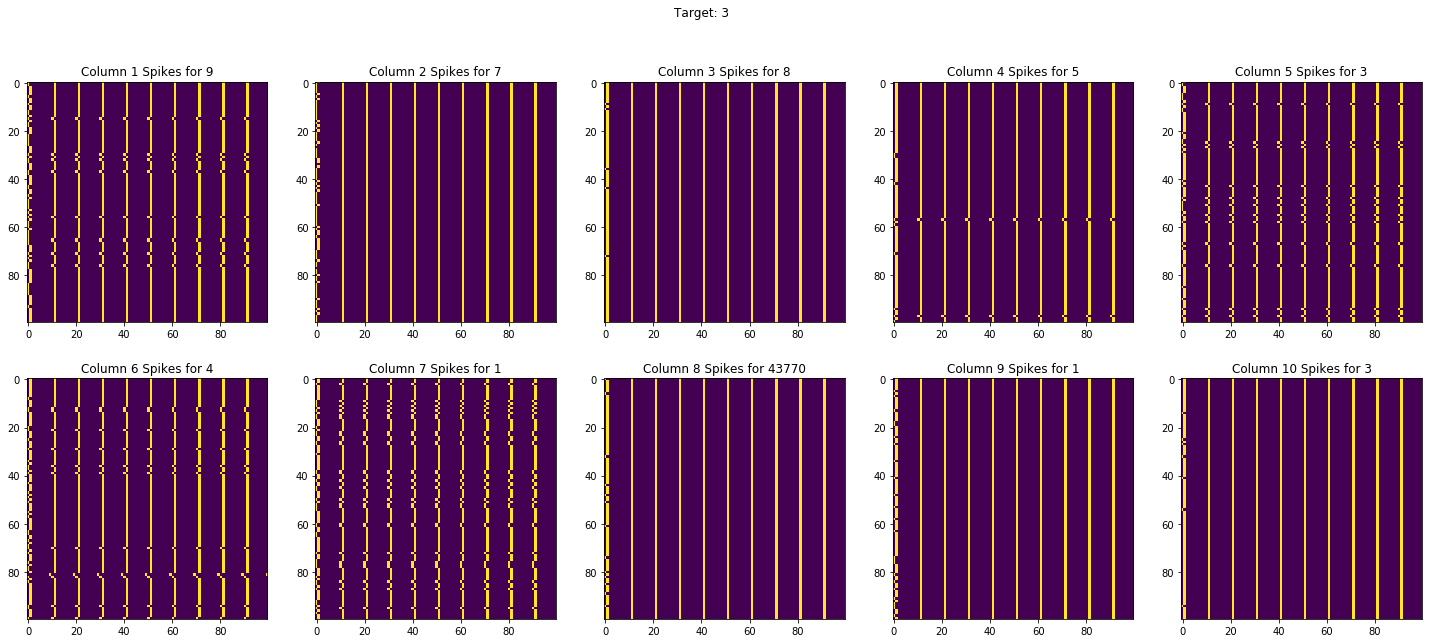

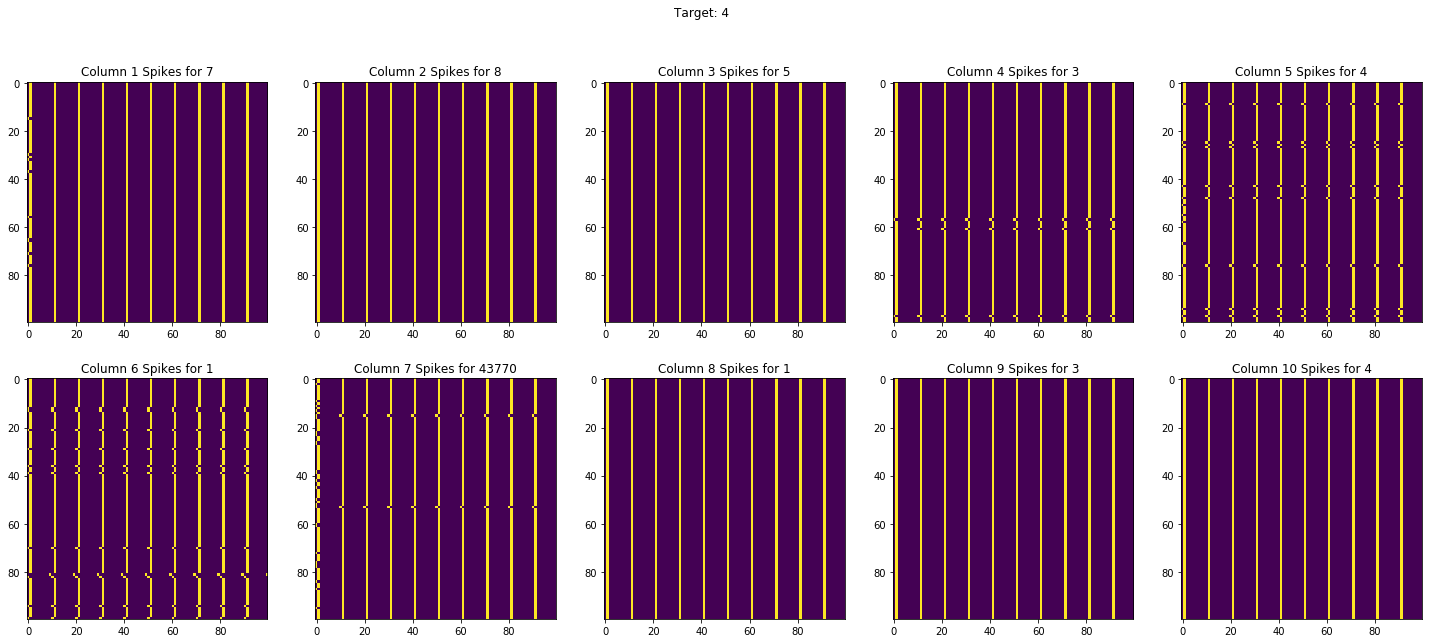

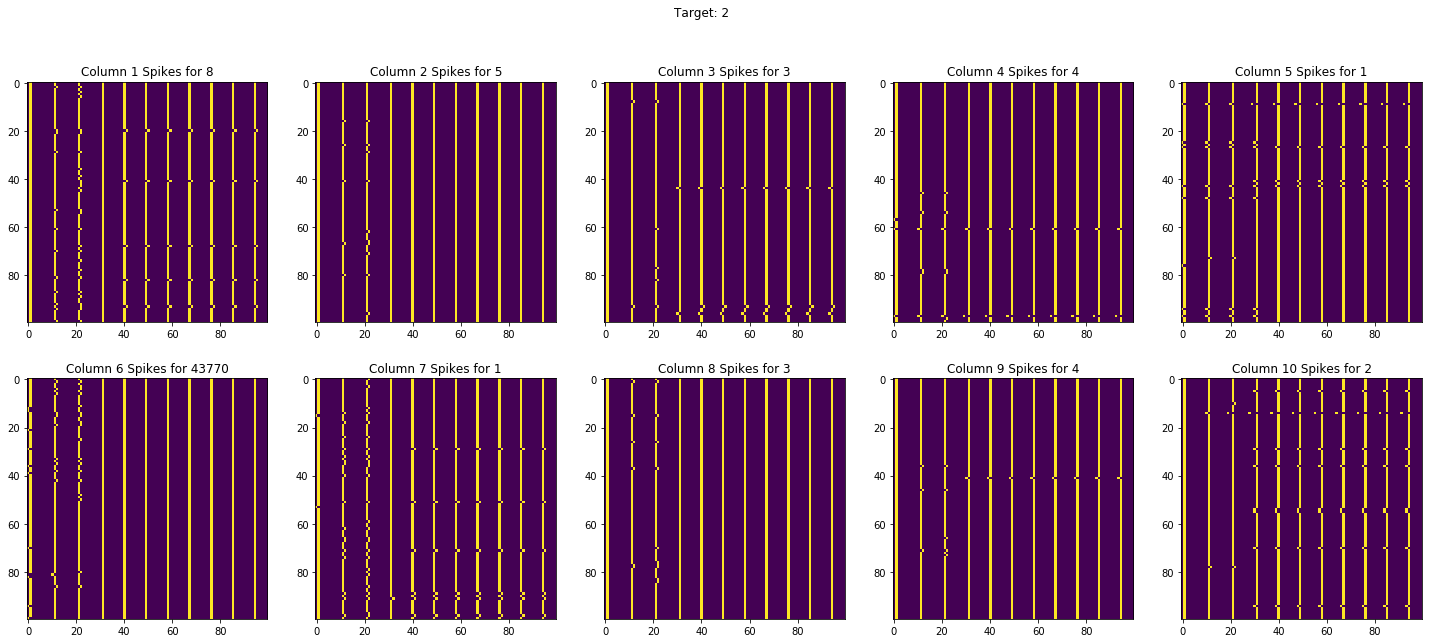

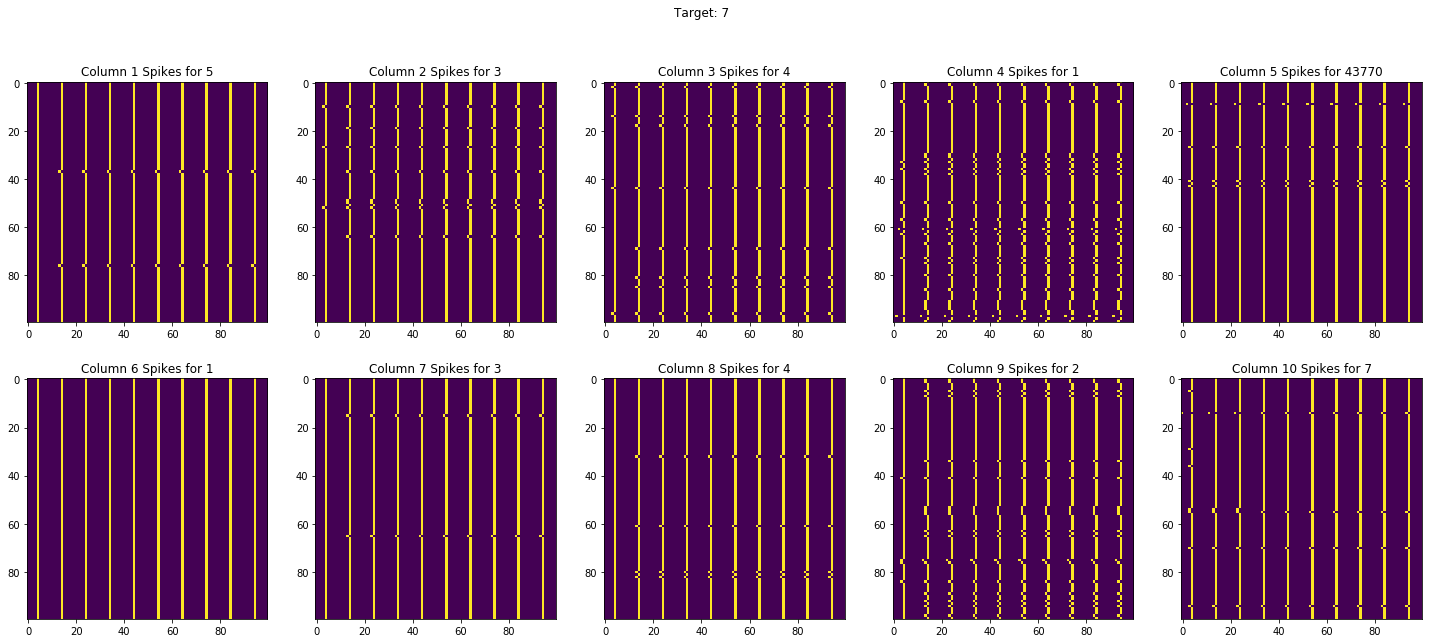

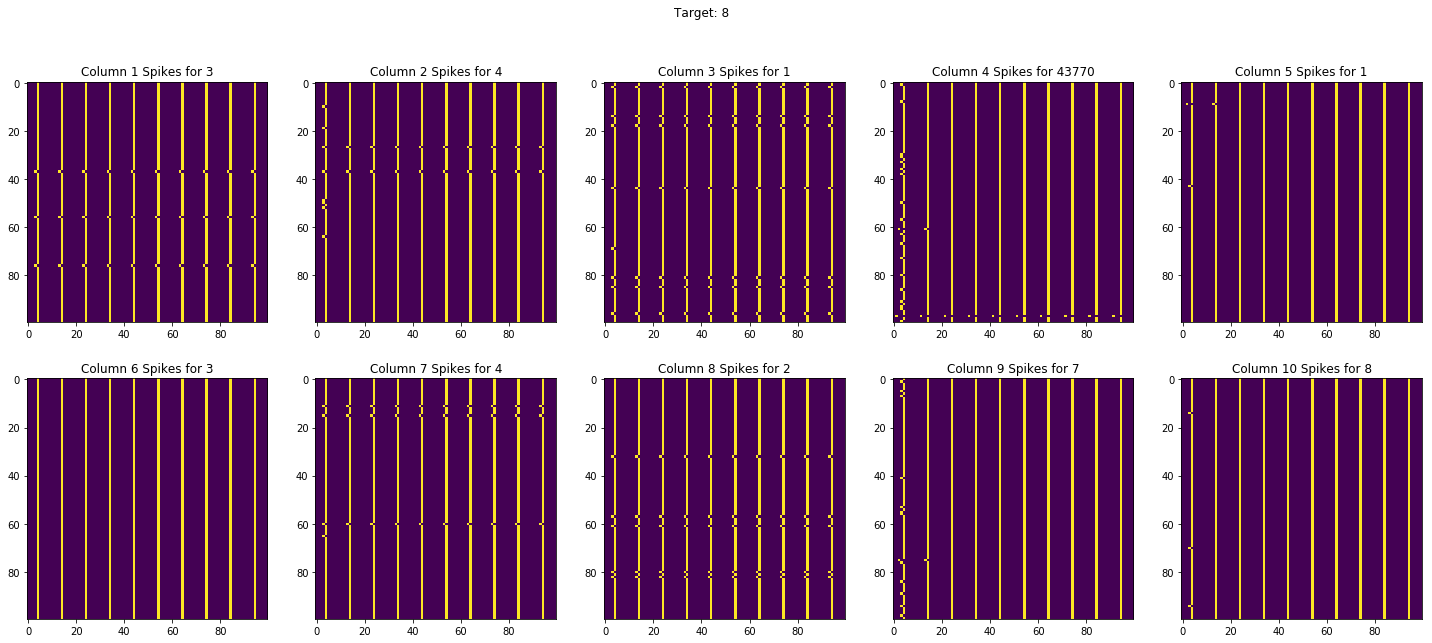

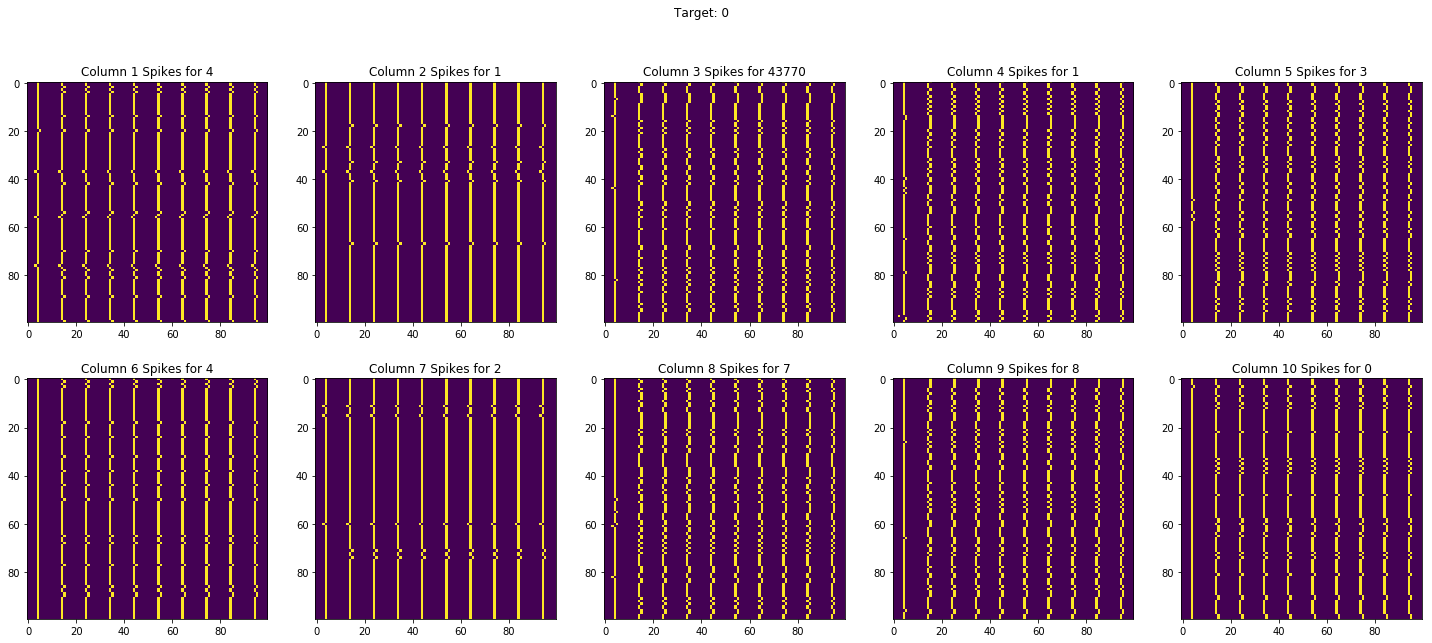

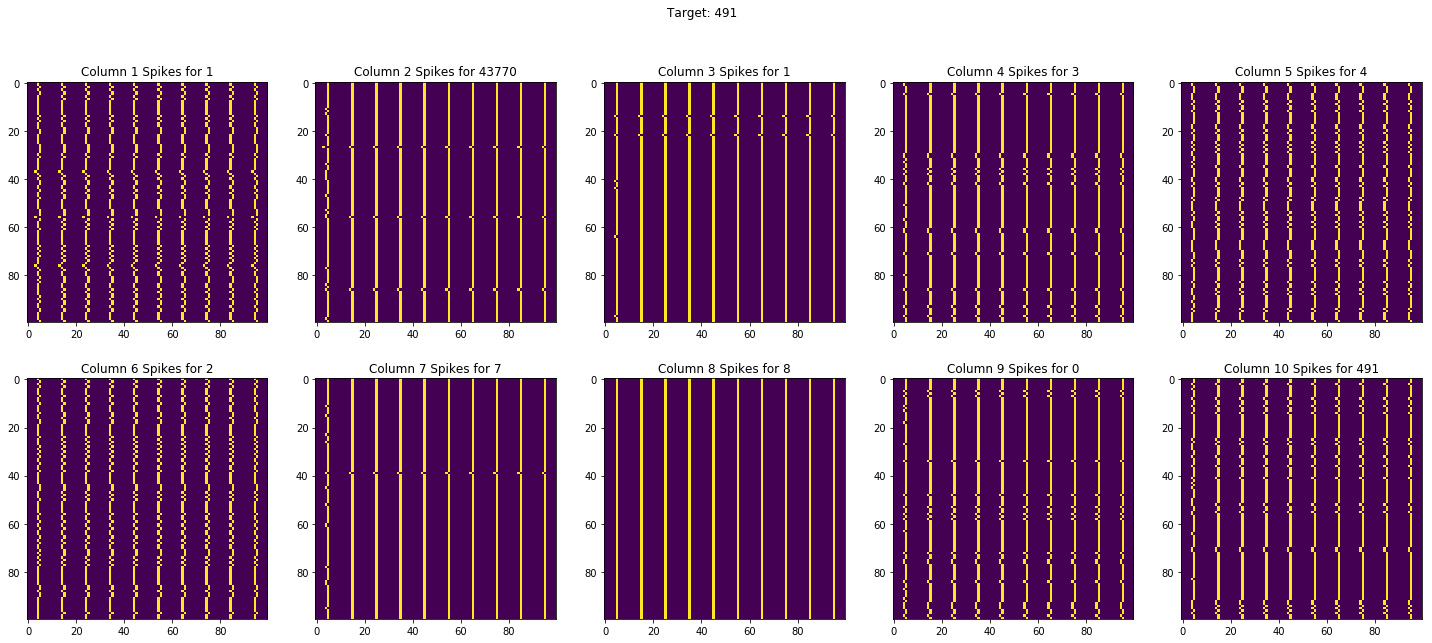

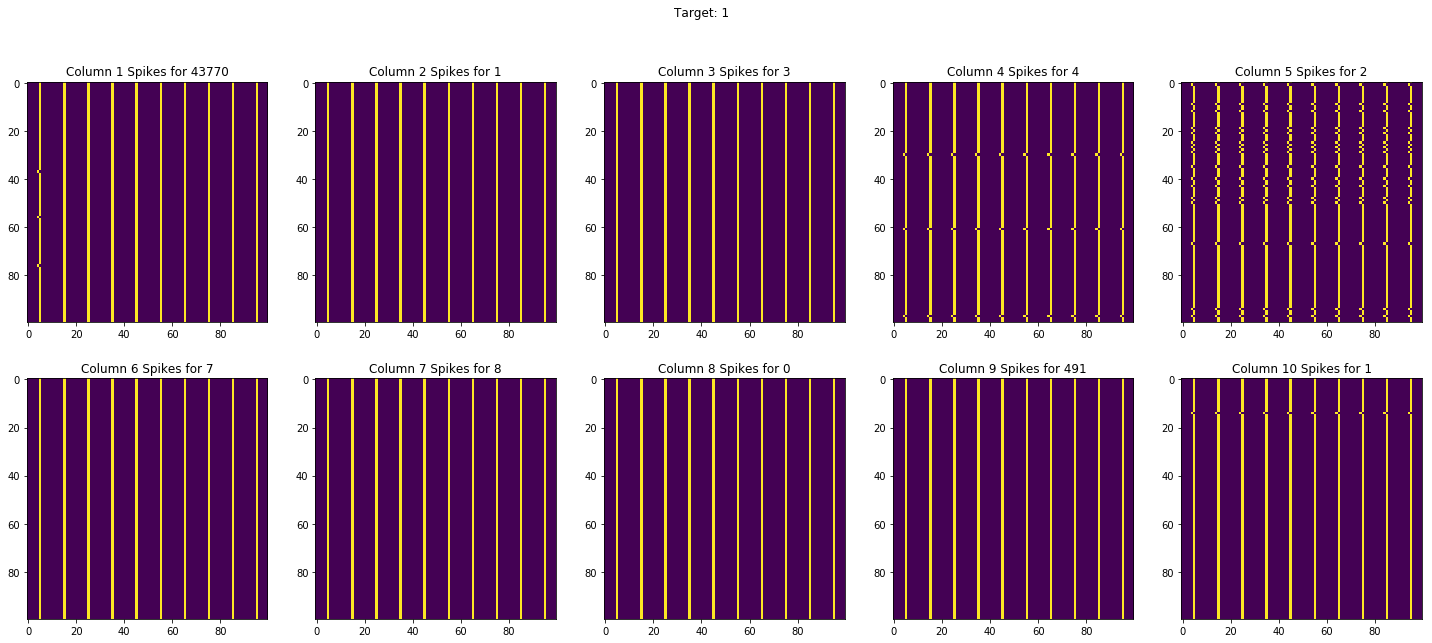

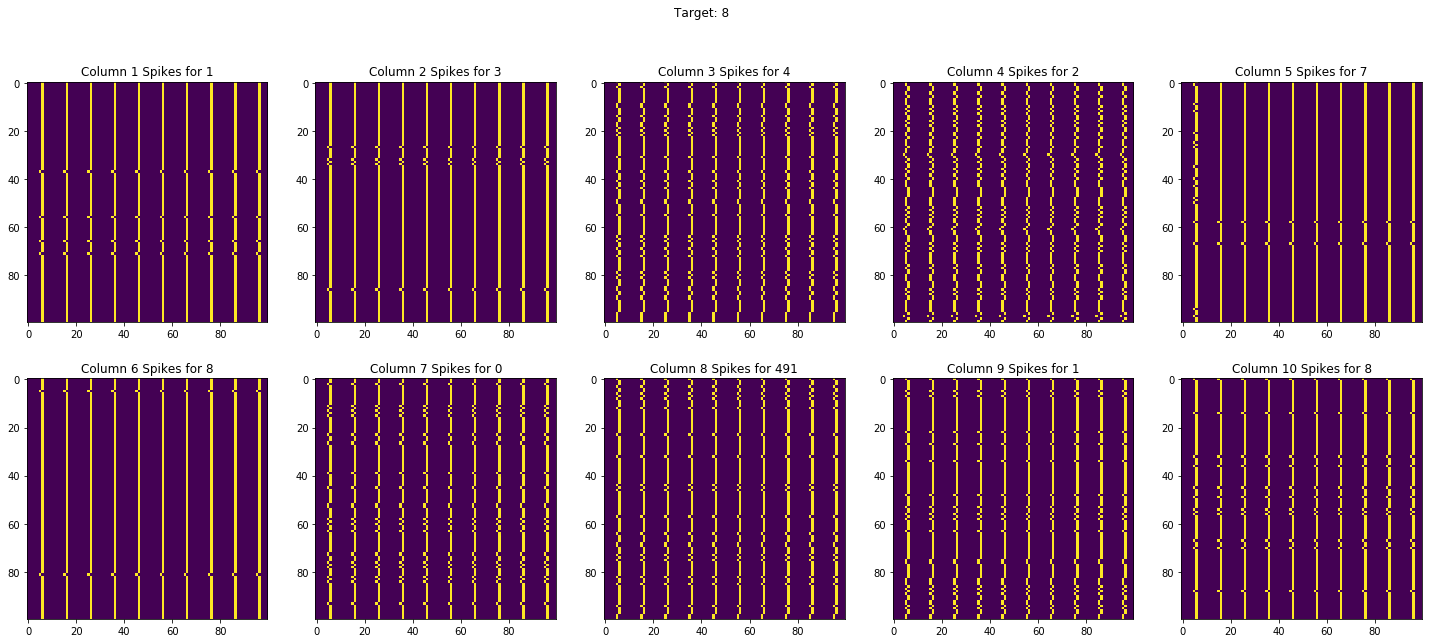

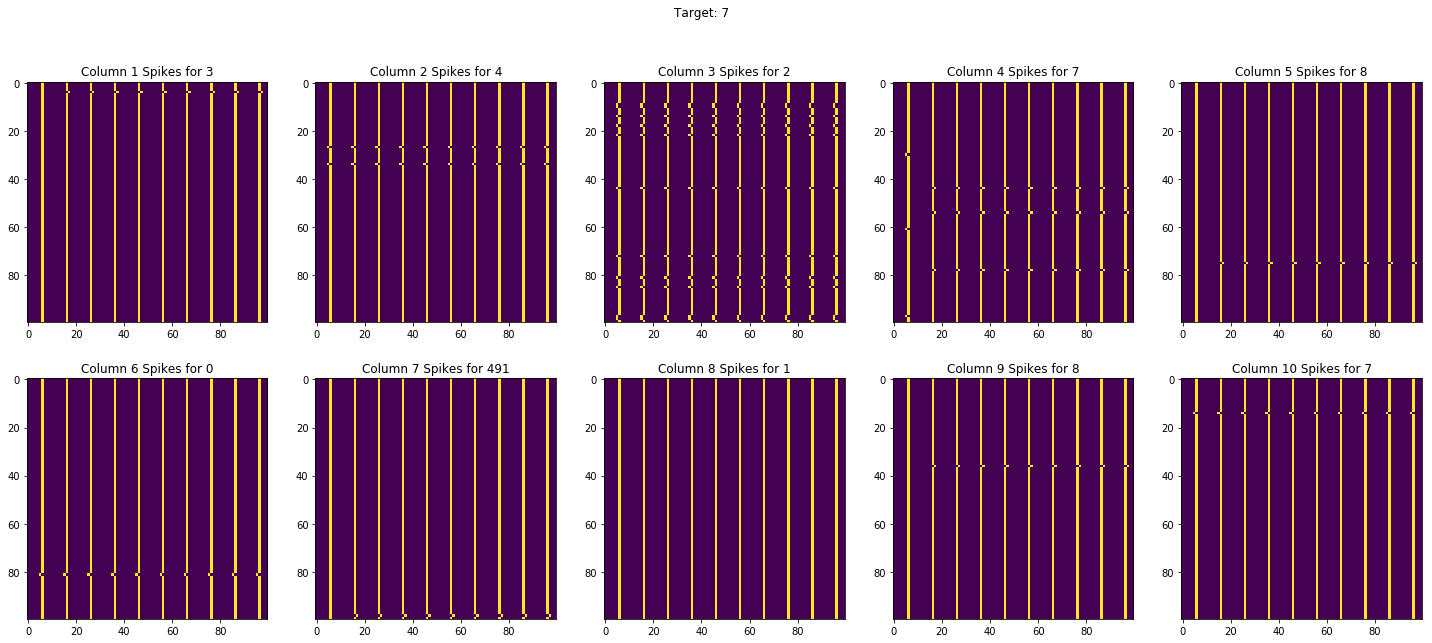

In [10]:
for cur in range(10, 20):#len(stream)):
    inpt = {f'input_{i+1}': stream[cur+i-10] for i in range(lag)}
    target = stream[cur]
    net.run(inpt)
    
    plt.figure(figsize=(25, 10))
    plt.suptitle(f'Target: {target}')
    for i in range(lag):
        plt.subplot(2, lag//2, i+1)
        plt.title(f'Column {i+1} Spikes for {stream[cur+i-9]}')
        plt.imshow(net.monitors[f'monitor_{i+1}'].get('s'))
    plt.pause(1e-5)